
#### -------------------------------------
#### Step 1: Import and Organize Data
#### -------------------------------------

In [83]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, FunctionTransformer, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score
from category_encoders import TargetEncoder

from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
import plotly.graph_objects as go

from sklearn.linear_model import LogisticRegression

import xgboost as xgb
from xgboost import XGBClassifier


import optuna
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
import warnings
warnings.filterwarnings('ignore')

In [84]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sub = pd.read_csv('sample_submission.csv')

In [157]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140700 entries, 0 to 140699
Data columns (total 20 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   id                                     140700 non-null  int64  
 1   Name                                   140700 non-null  float64
 2   Gender                                 140700 non-null  object 
 3   Age                                    140700 non-null  float64
 4   City                                   140700 non-null  float64
 5   Working_Professional_or_Student        140700 non-null  object 
 6   Profession                             104070 non-null  object 
 7   Academic_Pressure                      27897 non-null   float64
 8   Work_Pressure                          112782 non-null  float64
 9   CGPA                                   27898 non-null   float64
 10  Study_Satisfaction                     27897 non-null   

,id,Name,Gender,Age,City,Working_Professional_or_Student,Profession,Academic_Pressure,Work_Pressure,CGPA,Study_Satisfaction,Job_Satisfaction,Sleep_Duration,Dietary_Habits,Degree,Have_you_ever_had_suicidal_thoughts_?,Work/Study_Hours,Financial_Stress,Family_History_of_Mental_Illness,Depression
0,0,0.194621,Female,49.0,0.192690,Working Professional,Chef,NaN,5.0,NaN,NaN,2.0,More than 8 hours,Healthy,BHM,No,1.0,2.0,No,0
1,1,0.186916,Male,26.0,0.142206,Working Professional,Teacher,NaN,4.0,NaN,NaN,3.0,Less than 5 hours,Unhealthy,LLB,Yes,7.0,3.0,No,1
2,2,0.172603,Male,33.0,0.159196,Student,NaN,5.0,NaN,8.97,2.0,NaN,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
3,3,0.172603,Male,22.0,0.131293,Working Professional,Teacher,NaN,5.0,NaN,NaN,1.0,Less than 5 hours,Moderate,BBA,Yes,10.0,1.0,Yes,1
4,4,0.180361,Female,30.0,0.125739,Working Professional,Business Analyst,NaN,1.0,NaN,NaN,1.0,5-6 hours,Unhealthy,BBA,Yes,9.0,4.0,Yes,0


In [ ]:
# Replace spaces in column names with underscores for easier access
train.columns = [col.replace(' ', '_') for col in train.columns]
test.columns = [col.replace(' ', '_') for col in test.columns]
train.columns

In [ ]:
num_duplicates = train.duplicated().sum()
num_duplicates

In [ ]:
train.isnull().sum()

In [ ]:
print(f'Train Set Types: \n {train.dtypes},''\n\n\n',f'Test Set Types: \n {test.dtypes}')

In [ ]:
for column in train.columns:
    unique_values = train[column].unique()
    print(f"Column: {column}")
    print(f"Unique Values: {unique_values}")

    

#### -----------------------------------------------------------
#### Step 2: Preprocessing: Feature Engineering and Pipeline
#### -----------------------------------------------------------

In [91]:
class RenameColumnsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Renaming columns
        df.rename(columns={
            "Have_you_ever_had_suicidal_thoughts_?": "Suicidal_Thoughts",
            "Family_History_of_Mental_Illness": "Family_History",
        }, inplace=True)

        return df

#          Suicidal_Thoughts        Family_History  Age
# 0              Yes                   Yes           25
# 1               No                    No           30
# 2              Yes                    No           22


In [93]:
class TargetEncodeCategoricalVariablesWithCVTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, cols=None, n_splits=5, random_state=42):
        if cols is None:
            self.cols = ['Profession', 'Degree', 'City']
        else:
            self.cols = cols
        self.n_splits = n_splits
        self.random_state = random_state
        self.target_encoder = TargetEncoder(cols=self.cols)

    def fit(self, df, y=None):
        if 'Depression' in df.columns:
            self.df = df.copy()
            self.y = y
        return self

    def transform(self, df):
        df = df.copy()
        
        if 'Depression' in df.columns:
            # Initializing cross-validation
            kf = StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=self.random_state)

            for train_index, val_index in kf.split(self.df, self.df['Depression']):
                train_fold = self.df.iloc[train_index]
                val_fold = self.df.iloc[val_index]

                # Applying TargetEncoder to columns for training and validation
                self.target_encoder.fit(train_fold[self.cols], train_fold['Depression'])
                val_fold_encoded = self.target_encoder.transform(val_fold[self.cols])

                # Updating the transformed columns in the validation set
                df.loc[val_index, self.cols] = val_fold_encoded
        else:
            # Applying TargetEncoder directly without cross-validation
            df[self.cols] = self.target_encoder.transform(df[self.cols])
        
        return df
    
#     Profession   Degree    City  Depression
# 0   0.600000  0.700000  0.500      1
# 1   0.300000  0.200000  0.700      0
# 2   0.700000  0.400000  0.600      1
# 3   0.400000  0.200000  0.500      0
# 4   0.500000  0.700000  0.300      1


In [94]:
# Encoding Categorical Variables
class EncodeCategoricalVariablesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.label_encoders = {}

    def fit(self, df, y=None):
        # Initialize LabelEncoders for binary columns only
        self.binary_columns = ['Family_History', 'Suicidal_Thoughts', 'Gender',
                               'Working_Professional_or_Student']
        for col in self.binary_columns:
            if col in df.columns:
                le = LabelEncoder()
                le.fit(df[col].fillna('-1').astype(str))
                self.label_encoders[col] = le
        return self

    def transform(self, df):
        df = df.copy()

        # Apply LabelEncoder to binary columns
        for col in self.binary_columns:
            if col in df.columns:
                le = self.label_encoders.get(col)
                if le is not None:
                    df[col] = le.transform(df[col].fillna('-1').astype(str))


        diet_mapping = {
            'More Healty': 0,
            'Healthy': 1,
            'Less than Healthy': 2,
            'Less Healthy': 2,
            'Moderate': 3,
            'Unhealthy': 4,
            'No Healthy': 4,
        }
        if "Dietary_Habits" in df.columns:
            df['Dietary_Habits'] = df['Dietary_Habits'].map(diet_mapping)
            df['Dietary_Habits'] = df['Dietary_Habits'].fillna(
                df['Dietary_Habits'].mode().iloc[0]
            )
            
        return df
#        Family_History  Suicidal_Thoughts  Gender  Working_Professional_or_Student  Dietary_Habits
# 0              1                  1       1                                 1               1
# 1              0                  0       0                                 0               4
# 2              0                  2       2                                 2               2
# 3              1                  1       3                                 0               0
# 4              2                  0       1                                 1               1



In [ ]:
class ApplyPressureLogicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        
        df['Academic_Pressure'] = df.apply(
            lambda row: np.nan if row['Working_Professional_or_Student'] == 1
            else row['Academic_Pressure'], axis=1
        )
        
        df['Work_Pressure'] = df.apply(
            lambda row: np.nan if row['Working_Professional_or_Student'] == 0
            else row['Work_Pressure'], axis=1
        )
        
        return df
    # Output of the example:
#    Working_Professional_or_Student  Academic_Pressure  Work_Pressure
# 0                               0              7.0            NaN
# 1                               1              NaN            6.0
# 2                               0              8.0            NaN
# 3                               1              NaN            7.0

In [ ]:
# Creating Derived Columns
class CreateDerivedColumnsTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()

        if 'Gender' in df.columns and 'Work_Pressure' in df.columns:
            gender_work_pressure_mean = df.groupby('Gender')['Work_Pressure'].mean().to_dict()
            df['Gender_Work_Pressure'] = df['Gender'].map(gender_work_pressure_mean)

        if 'Suicidal_Thoughts' in df.columns and 'Job_Satisfaction' in df.columns:
            suicidal_job_satisfaction_mean = df.groupby('Suicidal_Thoughts')['Job_Satisfaction'].mean().to_dict()
            df['Suicidal_Job_Satisfaction'] = df['Suicidal_Thoughts'].map(suicidal_job_satisfaction_mean)

        if 'Financial_Stress' in df.columns and 'Academic_Pressure' in df.columns:
            financial_academic_pressure_mean = df.groupby('Financial_Stress')['Academic_Pressure'].mean().to_dict()
            df['Financial_Academic_Pressure'] = df['Financial_Stress'].map(financial_academic_pressure_mean)

        if 'Financial_Stress' in df.columns and 'Study_Satisfaction' in df.columns:
            financial_study_satisfaction_mean = df.groupby('Financial_Stress')['Study_Satisfaction'].mean().to_dict()
            df['Financial_Study_Satisfaction'] = df['Financial_Stress'].map(financial_study_satisfaction_mean)

        return df
    #   Gender  Work_Pressure  Suicidal_Thoughts  Job_Satisfaction Financial_Stress  Academic_Pressure  Study_Satisfaction  Gender_Work_Pressure  Suicidal_Job_Satisfaction  Financial_Academic_Pressure  Financial_Study_Satisfaction
# 0   Male              5               True                 3             High                  7                 4                5.5                     2.5                       7.5                          3.5
# 1   Female              7              False                 9              Low                  2                 9                7.5                     8.5                       2.5                          8.5
# 2   Male              6               True                 2             High                  8                 3                5.5                     2.5                       7.5                          3.5
# 3   Female              8              False                 8              Low                  3                 8                7.5                     8.5                       2.5                          8.5


In [ ]:
class ApplyWorkStudyHoursLogicTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):

        return self
    
    def transform(self, df):
        
        df = df.copy()

        df['Work_Hours'] = df.apply(
            lambda row: np.nan if pd.isna(row['Work/Study_Hours']) 
            else row['Work/Study_Hours'] if row['Working_Professional_or_Student'] == 1
            else 0,
            axis=1
        )
        
        df['Study_Hours'] = df.apply(
            lambda row: np.nan if pd.isna(row['Work/Study_Hours']) 
            else row['Work/Study_Hours'] if row['Working_Professional_or_Student'] == 0
            else 0,
            axis=1
        )
        
        df.drop(['Work/Study_Hours'], axis=1, inplace=True)
        
        return df
    
# Example Output:
#    Working_Professional_or_Student  Work_Hours  Study_Hours
# 0                               0         0.0       8.0
# 1                               1         6.0       0.0
# 2                               0         0.0      10.0
# 3                               1         4.0       0.0
# 4                               0         0.0       NaN

In [99]:
degree = {
    "BCom": "B.Com", "B.Com": "B.Com", "B.Comm": "B.Com",
    "B.Tech": "B.Tech", "BTech": "B.Tech", "B.T": "B.Tech",
    "BSc": "B.Sc", "B.Sc": "B.Sc", "Bachelor of Science": "B.Sc",
    "BArch": "B.Arch", "B.Arch": "B.Arch",
    "BA": "B.A", "B.A": "B.A",
    "BBA": "BBA", "BB": "BBA",
    "BCA": "BCA",
    "BE": "BE",
    "BEd": "B.Ed", "B.Ed": "B.Ed",
    "BPharm": "B.Pharm", "B.Pharm": "B.Pharm",
    "BHM": "BHM",
    "LLB": "LLB", "LL B": "LLB", "LL BA": "LLB", "LL.Com": "LLB", "LLCom": "LLB",
    "MCom": "M.Com", "M.Com": "M.Com",
    "M.Tech": "M.Tech", "MTech": "M.Tech", "M.T": "M.Tech",
    "MSc": "M.Sc", "M.Sc": "M.Sc", "Master of Science": "M.Sc",
    "MBA": "MBA",
    "MCA": "MCA",
    "MD": "MD",
    "ME": "ME",
    "MEd": "M.Ed", "M.Ed": "M.Ed",
    "MArch": "M.Arch", "M.Arch": "M.Arch",
    "MPharm": "M.Pharm", "M.Pharm": "M.Pharm",
    "MA": "MA", "M.A": "MA",
    "MPA": "MPA",
    "LLM": "LLM",
    "PhD": "PhD",
    "MBBS": "MBBS",
    "CA": "CA",
    "Class 12": "Class 12", "12th": "Class 12",
    "Class 11": "Class 11", "11th": "Class 11"
}

train['Degree'] = train['Degree'].map(degree)
test['Degree'] = test['Degree'].map(degree)

In [100]:
mean_n = train.groupby('Name')['Depression'].mean()
train['Name'] = train['Name'].map(mean_n)
test['Name'] = test['Name'].map(mean_n)

mean_n = train.groupby('City')['Depression'].mean()
train['City'] = train['City'].map(mean_n)
test['City'] = test['City'].map(mean_n)

In [ ]:
# Sleep Duration Standardization
class StandardizeSleepDurationTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df = df.copy()
        sleep_mapping = {
            'More than 8 hours': 9,  
            'Less than 5 hours': 4,  
            '5-6 hours': 5.5,
            '6-7 hours': 6.5,
            '7-8 hours': 7.5,
            '8-9 hours': 8.5,
            '9-11 hours': 10, 
            '10-11 hours': 10.5,
            '4-6 hours': 5,
            '6-8 hours': 7,
            '1-2 hours': 1.5,
            '2-3 hours': 2.5,
            '3-4 hours': 3.5,
            '4-5 hours': 4.5,
            '8 hours' : 8,
            '1-3 hours': 2,
            '3-6 hours' : 4.5,
            '9-6 hours' : 7.5
        }
        if "Sleep_Duration" in df.columns:
            df['Sleep_Duration'] = df['Sleep_Duration'].map(sleep_mapping)
            df['Sleep_Duration'] = df['Sleep_Duration'].fillna(df['Sleep_Duration'].median())
            
        return df
    
# Example Output (median will depend on the data):
#      Sleep_Duration
# 0             7.5
# 1             4.0
# 2             5.5
# 3             9.0
# 4             7.0
# 5             7.5  # Filled with median
# 6             7.5

In [102]:
class FillMissingValuesWithMedianTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.medians = {}
        
    def fit(self, X, y=None):
        # Calculates the median for all numeric columns with missing values
        self.medians = X.median(numeric_only=True).to_dict()
        return self
    
    def transform(self, df):
        df = df.copy()
        
        # Fills in missing values ​​with calculated medians
        for col, median in self.medians.items():
            if col in df.columns:
                df[col] = df[col].fillna(median)
        
        return df

In [139]:
# Pipeline definition
pipeline = Pipeline([
    ('rename_columns', RenameColumnsTransformer()),
    ('TargetEncode', TargetEncodeCategoricalVariablesWithCVTransformer()),
    ('encode_categorical', EncodeCategoricalVariablesTransformer()),
    ('create_columns', CreateDerivedColumnsTransformer()),
    ('logic_transform', ApplyPressureLogicTransformer()),
    ('work_study_logic', ApplyWorkStudyHoursLogicTransformer()),
    ('standardize_sleep', StandardizeSleepDurationTransformer()),
    ('fill_missing', FillMissingValuesWithMedianTransformer())
])

# Apply the pipeline to the data
train_df = pipeline.fit_transform(train)
test_df = pipeline.transform(test)
with open("train_transformed.pkl", "wb") as f:
    pickle.dump(train_df, f)
with open("my_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [140]:
print(f"Checking the number of missing values TRAIN:{chr(10)}")
print(train_df.isnull().sum())

print(f"{chr(10)}Checking the number of missing values TEST:{chr(10)}")
print(test_df.isnull().sum())

Checking the number of missing values TRAIN:

id                                 0
Name                               0
Gender                             0
Age                                0
City                               0
Working_Professional_or_Student    0
Profession                         0
Academic_Pressure                  0
Work_Pressure                      0
CGPA                               0
Study_Satisfaction                 0
Job_Satisfaction                   0
Sleep_Duration                     0
Dietary_Habits                     0
Degree                             0
Suicidal_Thoughts                  0
Financial_Stress                   0
Family_History                     0
Depression                         0
Gender_Work_Pressure               0
Suicidal_Job_Satisfaction          0
Financial_Academic_Pressure        0
Financial_Study_Satisfaction       0
Work_Hours                         0
Study_Hours                        0
dtype: int64

Checking the nu

In [141]:
train_df.Depression.value_counts()

Depression
0    115133
1     25567
Name: count, dtype: int64

In [142]:
train_df[['Profession', 'Degree']] = train_df[['Profession', 'Degree']].astype(float)
test_df[['Profession', 'Degree']] = test_df[['Profession', 'Degree']].astype(float)

In [143]:
id_col_tra= train_df['id']
train_df.drop(['id'],axis = 1,inplace = True)
id_col_test= test_df['id']
test_df.drop(['id'],axis = 1,inplace = True)
id_col_tra= train_df['Name']
train_df.drop(['Name'],axis = 1,inplace = True)
id_col_test= test_df['Name']
test_df.drop(['Name'],axis = 1,inplace = True)

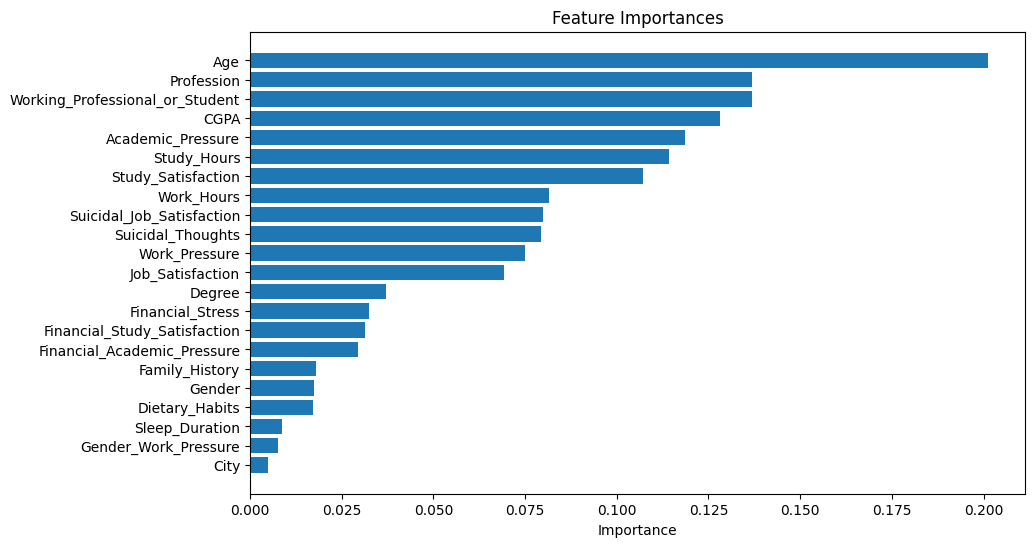

In [144]:
from sklearn.feature_selection import mutual_info_classif
mi = mutual_info_classif(train_df.drop('Depression', axis=1), train_df['Depression'])
mi_series = pd.Series(mi, index=train_df.drop('Depression', axis=1).columns)

feature_importance = pd.DataFrame({
    'Feature': train_df.drop('Depression', axis=1).columns,
    'Importance': mi_series
})

feature_importance = feature_importance.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()
plt.show()

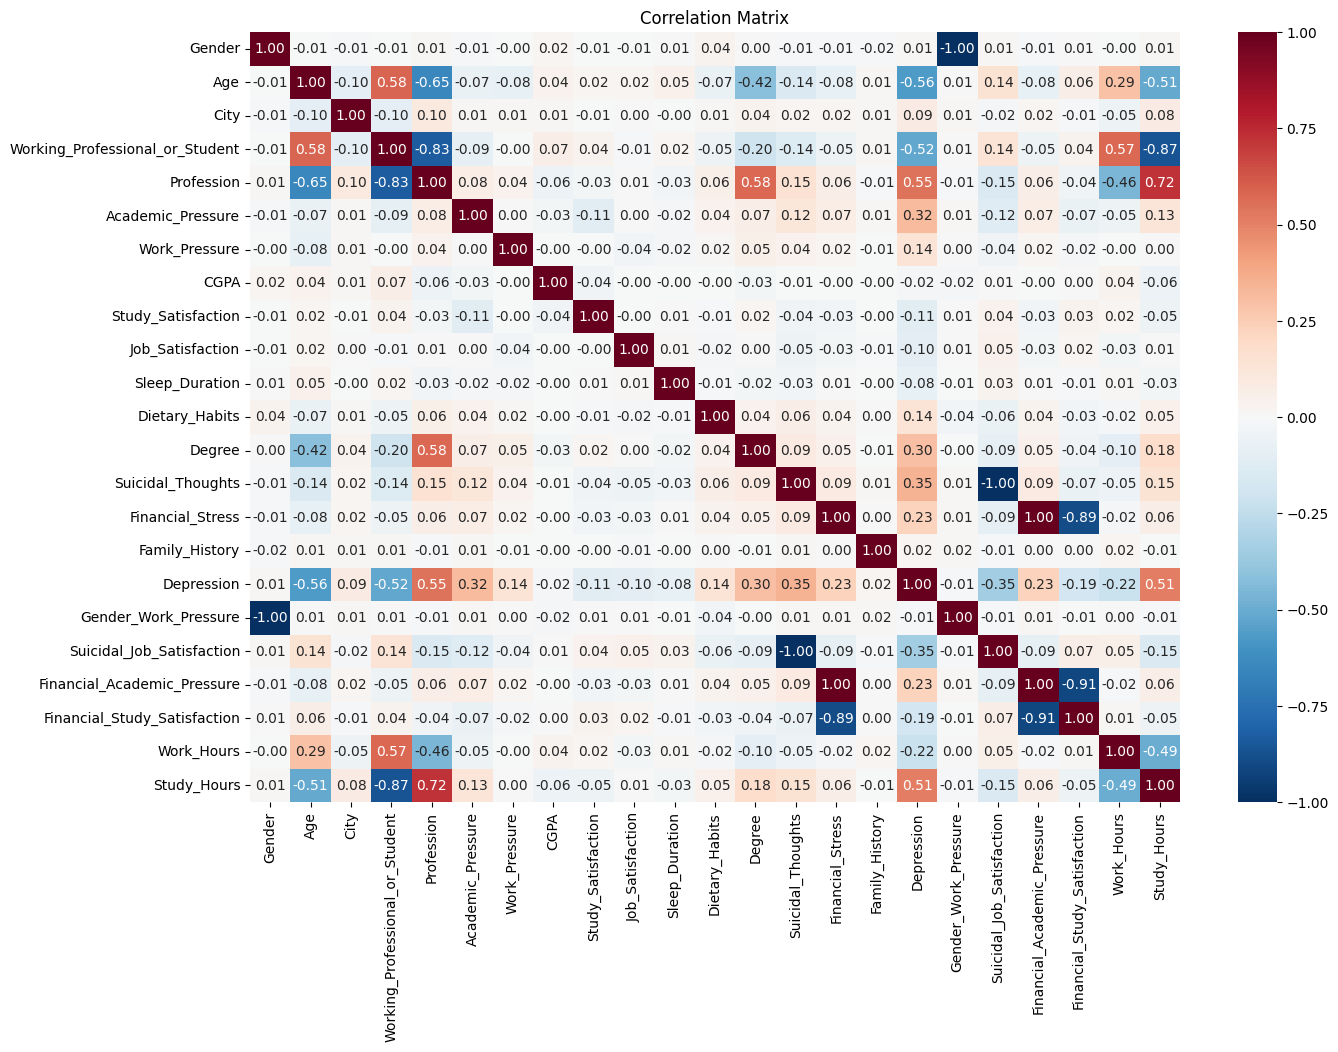

In [145]:
plt.figure(figsize=(15,10))
sns.heatmap(train_df.corr(), annot=True, cmap='RdBu_r',fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [146]:
# Target variable is the Depression column
X = train_df.drop(columns=['Depression'])
y = train_df['Depression']

# Split into training (80%) and validation (20%) sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [147]:
object_cols = train_df.select_dtypes(include=['object']).columns
print(object_cols)

Index([], dtype='object')


MODEL TRAINING 

In [148]:
# Scale numerical features (important for SVM and sometimes Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(test_df) #scaling test data

In [149]:
# Models
models = {
    
    "SVM": SVC(probability=True, random_state=42),  # probability=True for ROC AUC
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, solver='liblinear') # liblinear for potentially faster convergence
}

results = {}

In [150]:






for name, model in models.items():
    print(f"Training and evaluating {name}...")

    if name in ["SVM", "Logistic Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]  # Probabilities for ROC AUC
        test_pred = model.predict(X_test_scaled)
        test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:  #Random Forest
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        test_pred = model.predict(test_df)
        test_pred_proba = model.predict_proba(test_df)[:, 1]

    accuracy = accuracy_score(y_val, y_pred)
    cm = confusion_matrix(y_val, y_pred)

    # ROC AUC
    fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "fpr": fpr,
        "tpr": tpr,
        "roc_auc": roc_auc,
        "test_pred":test_pred,
        "test_pred_proba":test_pred_proba
    }

    # Print and plot results
    print(f"{name} Accuracy: {accuracy}")
    print(f"{name} Confusion Matrix:\n{cm}")

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
    
    #feature importance for random forest
    if name =="Random Forest":
        feature_importances = model.feature_importances_
        indices = np.argsort(feature_importances)[::-1]

        plt.figure(figsize=(12, 6))
        plt.title(f"{name} Feature Importance")
        plt.bar(range(10), feature_importances[indices[:10]], align="center")
        plt.xticks(range(10), X_train.columns[indices[:10]], rotation=90)
        plt.xlim([-1, 10])
        plt.tight_layout()
        plt.show()

Training and evaluating SVM...


KeyboardInterrupt: 

In [ ]:
best_model = None
best_accuracy = 0
best_model_name = ""

for name, model in models.items():
    if name in ["SVM", "Logistic Regression" ,"Random Forest"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
    
    accuracy = accuracy_score(y_val, y_pred)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_model_name = name

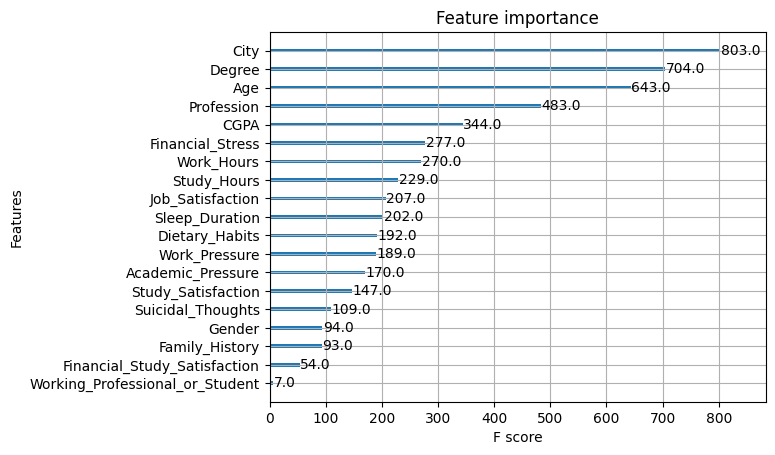

In [151]:
from sklearn.inspection import permutation_importance

# Train the model
model_xgb = XGBClassifier(enable_categorical=True, random_state=42)
model_xgb.fit(X_train, y_train)

# Display the importance of variables
xgb.plot_importance(model_xgb, importance_type='weight')
plt.show()

In [152]:
# Obtain the importance of variables using permutation
result = permutation_importance(model_xgb, X_val, y_val, n_repeats=15, random_state=42)

# Create a DataFrame with the importance of variables
permutation_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display the DataFrame with importance
print(permutation_importance_df)

                            Feature  Importance
1                               Age    0.090490
13                Suicidal_Thoughts    0.034328
14                 Financial_Stress    0.013035
6                     Work_Pressure    0.010114
5                 Academic_Pressure    0.009064
9                  Job_Satisfaction    0.008571
21                      Study_Hours    0.007773
4                        Profession    0.005487
11                   Dietary_Habits    0.004338
20                       Work_Hours    0.003840
3   Working_Professional_or_Student    0.001701
2                              City    0.001294
10                   Sleep_Duration    0.001163
7                              CGPA    0.000635
15                   Family_History    0.000580
12                           Degree    0.000389
19     Financial_Study_Satisfaction    0.000182
16             Gender_Work_Pressure    0.000000
17        Suicidal_Job_Satisfaction    0.000000
18      Financial_Academic_Pressure    0

In [153]:
def objective(trial):

    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
              
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 400, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.005, 0.1),
        'subsample': trial.suggest_float('subsample', 0.6, 0.8),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.05, 1),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.05, 4),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.05, 4),
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 10),
        'random_state': 42,
        'eval_metric': 'logloss',  # Add eval_metric
        'scale_pos_weight': scale_pos_weight,
        'use_label_encoder': False,
        'early_stopping_rounds': 50, # Suppress the warning.  Important!
    }

    model = XGBClassifier(**param)

    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        
        verbose=False
    )
    
    preds = model.predict(X_val)
    score = accuracy_score(y_val, preds)
    
    return score

In [ ]:
object_cols = train_df.select_dtypes(include=['object']).columns
print(object_cols)

In [154]:
# Study Setup
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler(seed=42))
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Optimization
study.optimize(objective, n_trials=100)

# Result
best_xgb_params = study.best_params
print(f"Melhores parâmetros: {best_xgb_params}")

Melhores parâmetros: {'n_estimators': 1000, 'max_depth': 10, 'learning_rate': 0.026399962736710376, 'subsample': 0.7537974830361022, 'colsample_bytree': 0.9475274433883066, 'gamma': 0.42482369533870573, 'reg_alpha': 0.14780723746857538, 'reg_lambda': 0.360077543351206, 'min_child_weight': 5}


In [155]:
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import joblib
xgb_model = XGBClassifier(**best_xgb_params, verbose=0)

# Defining the validation set
eval_set = [(X_train, y_train), (X_val, y_val)]

# Training the model
xgb_model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

# Making predictions on the validation set
y_pred = xgb_model.predict(X_val)
joblib.dump(xgb_model, "best_xgb_model.pkl") 
# Calculating accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Viewing the ranking report
print(classification_report(y_val, y_pred))

# Calculating the ROC AUC
roc_auc = roc_auc_score(y_val, xgb_model.predict_proba(X_val)[:, 1])
print(f'ROC AUC: {roc_auc:.4f}')

if accuracy > best_accuracy:
    best_accuracy = accuracy
    best_model = xgb_model
    best_model_name = "Xgboost"

Accuracy: 0.9362
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     22986
           1       0.84      0.81      0.82      5154

    accuracy                           0.94     28140
   macro avg       0.90      0.89      0.89     28140
weighted avg       0.94      0.94      0.94     28140

ROC AUC: 0.9742


NameError: name 'best_accuracy' is not defined

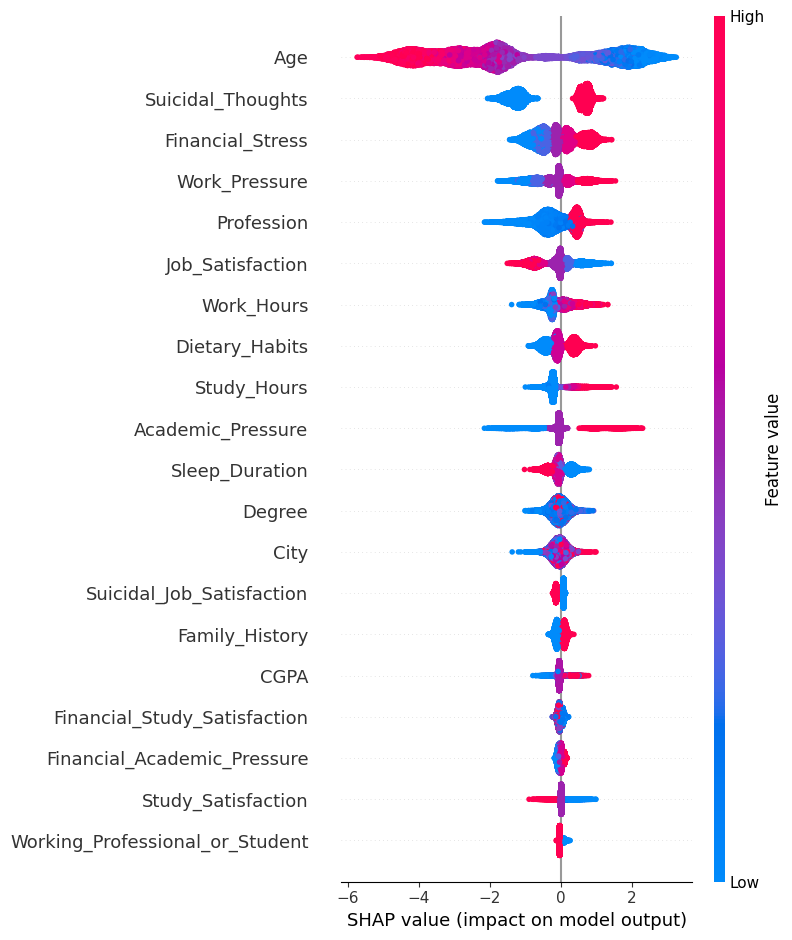

In [156]:
import shap

# Initialize SHAP explainer for XGBoost
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_val)

# Summary plot
shap.summary_plot(shap_values, X_val)


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall 

In [74]:
# Experimental: Combined oversampling e undersampling
smote_enn = SMOTEENN(sampling_strategy='auto')
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)

# Scale the data (after SMOTE)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_resampled)
X_val_scaled = scaler.transform(X_val)

In [75]:
model = Sequential([
    Dense(512, activation='relu', input_dim=X_train_scaled.shape[1], 
          kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.6),
    Dense(256, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Callbacks
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=5, 
    min_lr=0.000001
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=70, 
    restore_best_weights=True
)

# Setting class weights
total = len(y_resampled)
class_weights = {
    0: total / (2 * np.bincount(y_resampled)[0]),
    1: total / (2 * np.bincount(y_resampled)[1]) * 2  
}

In [76]:
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

In [ ]:
# Training the model
history = model.fit(
    X_train_scaled, y_resampled,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[reduce_lr]
)

# Saving the complete model after training
model.save("trained_model.h5")

print("Model saved as 'trained_model.h5'")

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

# Predictions on the validation set
y_pred = (model.predict(X_val_scaled) > 0.5).astype("int32")
nn_accuracy = accuracy_score(y_val, y_pred)

if nn_accuracy > best_accuracy:
    best_accuracy = nn_accuracy
    best_model = model
    best_model_name = "Neural Network"

print(f"Best Model: {best_model_name} with Accuracy: {best_accuracy}")
if best_model_name == "Neural Network":
    model.save("best_model.h5")
    print("Best model saved as 'best_model.h5'")
# Metrics Report
print(classification_report(y_val, y_pred))
print("AUC-ROC:", roc_auc_score(y_val, model.predict(X_val_scaled)))

In [ ]:
import shap
import tensorflow as tf

# Convert input to NumPy if necessary
X_val_np = np.array(X_val_scaled)

# Use SHAP DeepExplainer for TensorFlow model
explainer = shap.Explainer(model, X_val_np)
shap_values = explainer(X_val_np)

# Summary plot
shap.summary_plot(shap_values, X_val_np)
